In [8]:
from sklearn.decomposition import PCA
import pickle

In [12]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-mobilenet.pickle', 'rb'))

In [9]:

num_feature_dimensions=100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

In [10]:
# Explain the importance of first 20 features
print(pca.explained_variance_ratio_[0:20])

[0.04808487 0.03902655 0.03520469 0.0229082  0.01972816 0.01739131
 0.01555806 0.01291987 0.01241799 0.01133363 0.01028689 0.00926208
 0.00849703 0.00841846 0.00785455 0.00749922 0.00687655 0.00677042
 0.00629248 0.00604648]


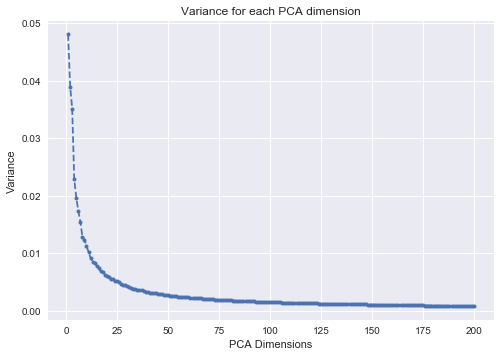

In [13]:
pca = PCA(200)
pca.fit(feature_list)
matplotlib.style.use('seaborn')
plt.plot(range(1,201),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

The individual variance will tell us how important the newly added features are. For example, after the first 100 dimensions, the additional dimensions don’t add much variance (almost equal to 0) and can be neglected. Without even checking the accuracy it is safe to assume that the PCA with 100 dimensions will be a robust model.

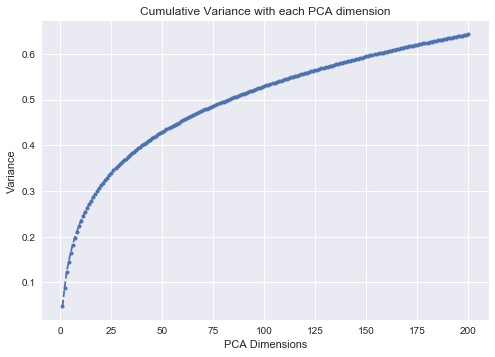

In [14]:
plt.plot(range(1,201),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4)
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

Another way to look at this is to visualize how much of the original data is explained by the limited number of features by finding the cumulative variance

adding 100 dimensions (from 100 to 200) adds only 0.1 variance and begins to gradually plateau. 

For reference, using the full 1024 features would result in a cumulative variance of 1

 One way to directly justify a good num_dimensions in PCA is to find a good balance between the number of features and its effect on accuracy versus speed:

In [21]:

import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib notebook

In [22]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [23]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (100.0, 258.852885723114)


In [24]:

pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  100.0 % ,	Time =  1.9789464473724365
For PCA Dimensions =  2 ,	Accuracy =  100.0 % ,	Time =  2.05996036529541
For PCA Dimensions =  3 ,	Accuracy =  100.0 % ,	Time =  2.0645577907562256
For PCA Dimensions =  4 ,	Accuracy =  100.0 % ,	Time =  2.60467791557312
For PCA Dimensions =  5 ,	Accuracy =  100.0 % ,	Time =  2.576634407043457
For PCA Dimensions =  10 ,	Accuracy =  100.0 % ,	Time =  3.0220913887023926
For PCA Dimensions =  20 ,	Accuracy =  100.0 % ,	Time =  3.5842909812927246
For PCA Dimensions =  50 ,	Accuracy =  100.0 % ,	Time =  4.768991470336914
For PCA Dimensions =  75 ,	Accuracy =  100.0 % ,	Time =  6.36144757270813
For PCA Dimensions =  100 ,	Accuracy =  100.0 % ,	Time =  7.804644823074341
For PCA Dimensions =  150 ,	Accuracy =  100.0 % ,	Time =  11.19800615310669
For PCA Dimensions =  200 ,	Accuracy =  100.0 % ,	Time =  15.102891445159912


<IPython.core.display.Javascript object>


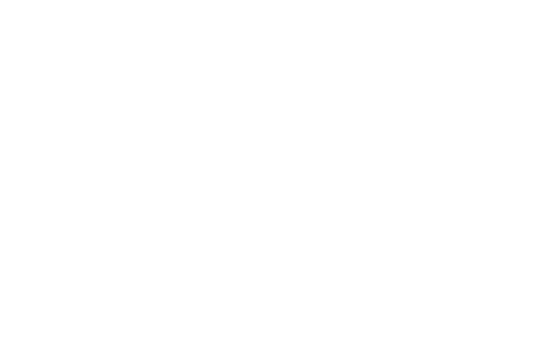

<IPython.core.display.Javascript object>


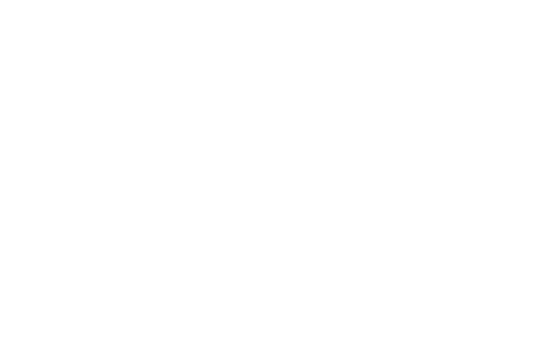

In [25]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')